In [1]:
import pandas as pd 
import seaborn as sns
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline
plt.style.use('ggplot')

In [2]:
olist_customers_dataset = pd.read_csv("/Users/anastasialutsuk/Desktop/Project_1/olist_customers_dataset.csv")

In [3]:
olist_order_items_dataset = pd.read_csv("/Users/anastasialutsuk/Desktop/Project_1/olist_order_items_dataset.csv", parse_dates = ['shipping_limit_date'])

In [4]:
olist_orders_dataset = pd.read_csv("/Users/anastasialutsuk/Desktop/Project_1/olist_orders_dataset.csv", parse_dates = ['order_purchase_timestamp'])

In [5]:
# customer_id является уникальным как в первой, так и во второй таблице 
print(olist_customers_dataset.customer_id.nunique() - olist_customers_dataset.customer_id.count())
print(olist_orders_dataset.customer_id.nunique() - olist_orders_dataset.customer_id.count())

0
0


In [6]:
# объеденим таблицы по customer_id
join_df =  olist_customers_dataset.merge(olist_orders_dataset, how='left', on='customer_id')
join_df =  join_df[['customer_id','order_status', 'order_id', 'order_purchase_timestamp', 
                    'order_delivered_customer_date', 'customer_unique_id']]
join_df[:4]

,customer_id,order_status,order_id,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,delivered,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,delivered,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,060e732b5b29e8181a18229c7b0b2b5e
3,b2b6027bc5c5109e529d4dc6358b12c3,delivered,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,259dac757896d24d7702b9acbbff3f3c


In [7]:
# Фактом совершения покупки будем считать "доставлен пользователю" и "дата доставки заказа не пустая":
# пока товар не доставлен клиент может его отменить или поменять какие-то условия

In [8]:
            # Определим сколько у нас пользователей, которые совершили покупку только один раз

In [9]:
# одну покупку совершило 90549 уникальных пользователей, при этом у нас всего уникальных покупок 96470
one_purchase = join_df[(join_df.order_delivered_customer_date.notnull() == True) & \
                       (join_df.order_status == "delivered")]\
                        .groupby('customer_unique_id', as_index=False)\
                        .agg({'order_id' : 'count'})
print(one_purchase[one_purchase.order_id == 1].customer_unique_id.count())
print(join_df[(join_df.order_delivered_customer_date.notnull() == True) & \
                       (join_df.order_status == "delivered")].order_id.nunique())

90549
96470


In [10]:
            # Определим сколько заказов в месяц в среднем не доставляется по разным причинам

In [11]:
# По полю время создания заказа добавим колонки по месяцу и дню недели, году и т.д
join_df['month'] = join_df.order_purchase_timestamp.dt.month # месяц
join_df['day'] = join_df.order_purchase_timestamp.dt.day_name() # день недели
join_df['days'] = join_df.order_purchase_timestamp.dt.day # номер дня в месяце
join_df['year'] = join_df.order_purchase_timestamp.dt.year # год
join_df['date'] = join_df.order_purchase_timestamp.astype('datetime64[M]') # месяц покупки

In [12]:
    # Исходя из статусов заказа можно сказать, что мы имеем 2 статуса где 100% недоставка:
        # "Отмена" и "заказ недоступен". 
        # "Заказ недоступен" может говорить о разных причинах : товара нет на складе, проблемы с сайтом

In [13]:
non_delivery = join_df.query("(order_status == 'unavailable') | (order_status == 'canceled')")\
                       .groupby(['month', 'order_status'], as_index=False)\
                       .agg({'order_id' : 'count'})\
                       .rename(columns = {'order_id' : 'count_orders'})
non_delivery[:2]

,month,order_status,count_orders
0,1,canceled,37
1,1,unavailable,58


<AxesSubplot:xlabel='month', ylabel='count_orders'>

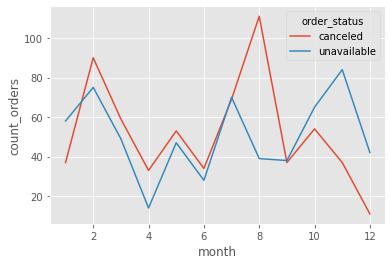

In [14]:
# На графике недоставленых заказов по месяцам можно заметить что чаще всего причиной недоставки является "отмена"
# Можно заметить что под конец года увеличиваются недоставки по причине "недоступен" и перекрывают отмены
# Это может быть связано с сезонностью : под конец года люди закупаются товарами перед праздниками 
# и многие товары становятся недоступними
sns.lineplot(y = non_delivery.count_orders, x = non_delivery.month, hue=non_delivery.order_status)

<AxesSubplot:xlabel='month', ylabel='count_orders'>

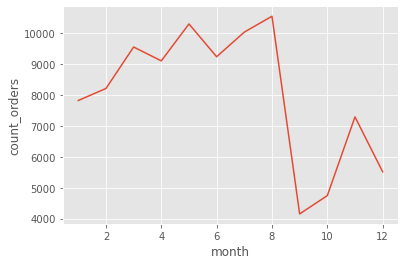

In [15]:
# Проверим теорию про сезонность
# Если товары недоступны по причине того, что очень много покупок перед празниками, то мы увидим рост объема покупок
# Данный всплеск сигнализировал бы о том, что многие товары проданы и на складе они закончились 
# Однако, на данном графике можно заметить, что под конец года идет значительное снижение числа доставленных покупок
# Возможно, есть проблемы с доставкой товаров или магазином в целом 
delivery = join_df[join_df.order_status == 'delivered'].groupby('month', as_index=False)\
                       .agg({'order_id' : 'count'})\
                       .rename(columns = {'order_id' : 'count_orders'})
sns.lineplot(y = delivery.count_orders, x = delivery.month)

In [16]:
# в месяц в среднем не доставляется по причине отмены - 52.08 заказа, недоступен - 50.75 заказа
# не смотря на то, что по графикам недоставка по причине "отмена" казалась более частой
# среднее значение не сильно отличается  
print('Отменен: ' + str(non_delivery[non_delivery.order_status == 'canceled'].count_orders.mean()))
print('Недоступен: ' + str(non_delivery[non_delivery.order_status == 'unavailable'].count_orders.mean()))

Отменен: 52.083333333333336
Недоступен: 50.75


In [17]:
               # Определим в какой день недели больше всего покупок

<AxesSubplot:xlabel='День недели', ylabel='Кол-во заказов'>

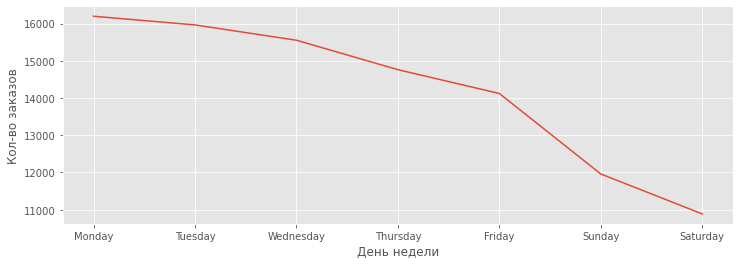

In [18]:
# Очевидно, что понедельник является наиболее привлекательным днем для формирования покупки 
# Для этой задачи не будем смотреть на отмены и факт доставки, мы хотим оценить желание пользователся купить товар
# То что происходит с товарами после
plt.figure(figsize=(12, 4))
day_cnt = join_df.groupby('day', as_index=False)\
                 .agg({'order_id' : 'count'})\
                 .sort_values('order_id', ascending=False)\
                 .rename(columns = {'order_id' : 'Кол-во заказов', 'day' : 'День недели'})
sns.lineplot(y = day_cnt['Кол-во заказов'], x = day_cnt['День недели'])

In [19]:
      #     Проведем когортный анализ пользователей
      #     Когорты будем строить на дату покупки и учитывать только доставленные покупки   

In [20]:
# Подготовим массив данных для анализа с датой доставки и статусом доставлен 
df = join_df[(join_df.order_delivered_customer_date.notnull() == True)&(join_df.order_status == "delivered")]

In [21]:
# Определим дату первой покупки клиента и в какую когорту он попадет 
first_buy = df.groupby('customer_unique_id', as_index=False)\
           .agg({'date' : 'min'})\
           .rename(columns={'date':'first_date'})
first_buy[:4]

,customer_unique_id,first_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01


In [22]:
# Подготовим календарь для расчета 
max_date = df['date'].max()
min_date = df['date'].min()
month = pd.DataFrame(pd.date_range(min_date, max_date, freq='MS')) # freq='MS' начало месяца
month.columns = ['month']
month['key'] = 1

In [23]:
# Подготовим перекрестную таблицу по пользователям и датам покупок
first_buy['key'] = 1
first_buy = first_buy.merge(month, on = 'key')[['customer_unique_id', 'first_date', 'month']]
first_buy[:3]

,customer_unique_id,first_date,month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-09-01
1,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-10-01
2,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2016-11-01


In [24]:
# Убираем месяца, где пользователь еще не совершил первую покупку 
first_buy = first_buy.query('first_date <= month')

In [25]:
# Подготовим таблицу по транзакциям 
transaction_month = df.groupby(['customer_unique_id', 'date'], as_index=False)\
                      .agg({'order_id' : 'count'})\
                      .rename(columns = {'date' : 'month', 'order_id' : 'cnt_order'})

In [58]:
# Соединим данные по транзакциям пользователей, где транзакций в месяце нет проставим 0
report = first_buy.merge(transaction_month, on = ['customer_unique_id', 'month'], how='left')
report['cnt_order'] = report['cnt_order'].fillna(0)

In [59]:
# Добавим флаг наличия транзакций за месяц
report['flg'] = (report['cnt_order']>0)*1

In [60]:
# Приведем дату первой покупки и даты транзакций к сокращенному формату
report['first_date'] = report.first_date.apply(lambda x : x.strftime('%Y-%m'))
report['month'] = report.month.apply(lambda x : x.strftime('%Y-%m'))

In [61]:
# Возьмем среднее значение от флага для расчета % активных пользователей в когорте
# Расчет среднего будет производится таким образом: в числителе суммируются флаги, в знам. посчитается кол-во пользоватлей когорты т.е кол-во 0 и 1 
retantion = report.groupby(['first_date', 'month'], as_index=False)\
                      .agg({'flg' : 'mean'})\
                      .pivot(index = 'first_date', columns = 'month', values = 'flg')

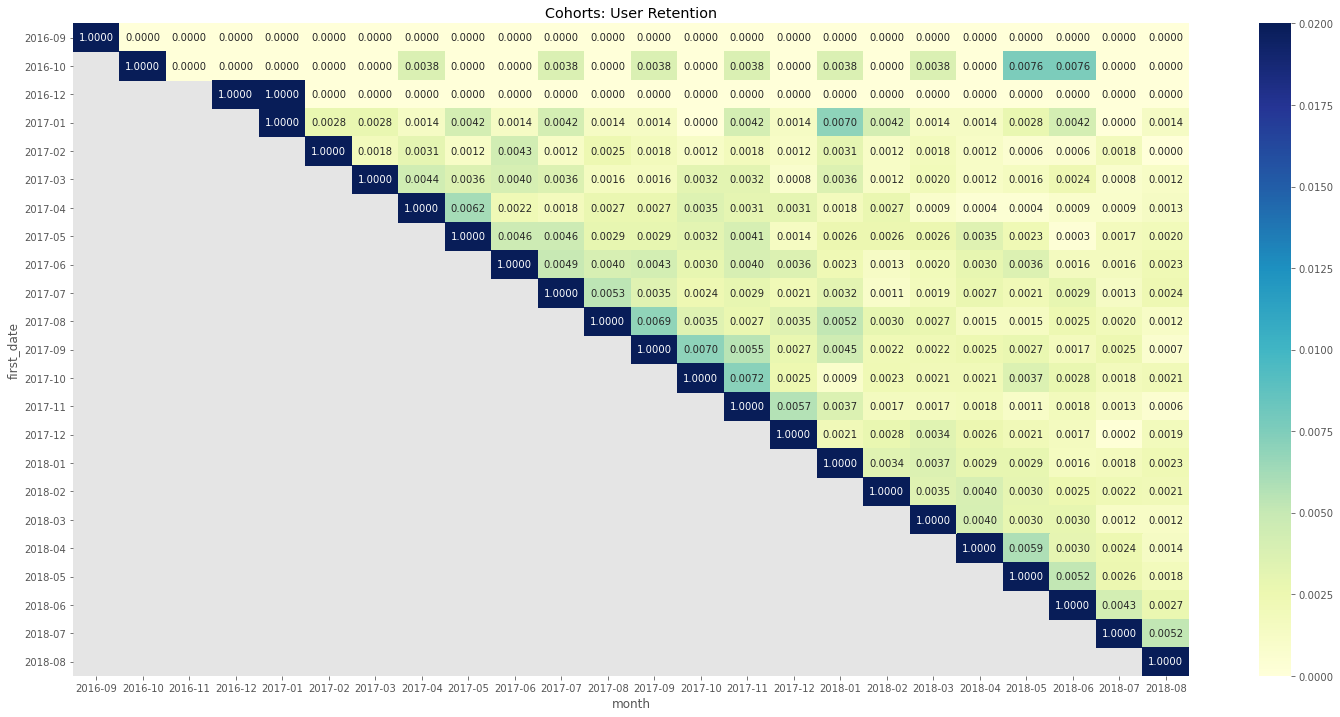

In [62]:
# В период с января по декабрь выявим когорту с самым высоким retention на 3й месяц
# самый большой % повторных покупок на 3 месяц у когорты 2017-09=0.0055
plt.figure(figsize=(25, 12))
plt.title('Cohorts: User Retention') 
sns.heatmap(retantion, annot=True, fmt='.4f', vmin=0.00, vmax=0.02,cmap="YlGnBu");

In [63]:
        #         Однако для данной задачи на таком графике очень сложно понять данную информацию
        #         Поэтому немного перестроим график

In [64]:
# Соединим данные по транзакциям пользователей с датой первой покупки
# Добавим поле с разницей между транзакцией и датой первой покупки в месяцах
report2 = first.merge(transaction_month, on = ['customer_unique_id'], how='left')
report2['cnt_month'] = ((report2.month.dt.year-report2.first_date.dt.year)*12) \
                        + (report2.month.dt.month-report2.first_date.dt.month)

NameError: name 'first' is not defined

In [ ]:
# Посчитаем уникальных пользователей в разрезе "даты первой покупки" и "кол-ва месяцев с первой покупки"
report_for_retantion = report2.groupby(['cnt_month', 'first_date'], as_index=False)\
                              .agg({'customer_unique_id' : pd.Series.nunique})
# Определим объем пользователей при формировании когорты (разница даты покупки с датой первой покупки 0 месяцев)
urers_first_day = report2.groupby(['first_date'], as_index=False)\
                         .agg({'customer_unique_id' : pd.Series.nunique})
# Добавим данные к основной таблице 
report_for_retantion = report_for_retantion.merge(urers_first_day, on = 'first_date', how='left')
# Посчитаем retantion = мера того, сколько человек отнсительно даты первой покупки 
# осталось через определённый временной промежуток
report_for_retantion['retantion'] = (report_for_retantion.customer_unique_id_x / 
                                     report_for_retantion.customer_unique_id_y)
report_for_retantion['first_date'] = report_for_retantion.first_date.apply(lambda x : x.strftime('%Y-%m'))
# Подготовим сводную и посмотрим на результаты
# 3 месяц = 2ой месяц после 0 (т.к 0 - месяц первой покупки и расчет идет с 0)
# теперь хорошо видно, что самый большой % возврата покупателей на 3 месяц на когорту 2017-09
report_for_retantion = report_for_retantion[['retantion', 'first_date', 'cnt_month']]\
                                        .pivot(values='retantion', index='first_date', columns='cnt_month')
plt.figure(figsize=(25, 12))
plt.title('Cohorts: User Retention') 
sns.heatmap(report_for_retantion, annot=True, fmt='.3f', vmin=0.00, vmax=0.02,cmap="YlGnBu");

In [ ]:
  #  Часто для качественного анализа аудитории используют подходы, основанные на сегментации. 
  #  Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
  #  В кластеризации будут следующие метрики: 
  #      R - время от последней покупки пользователя до текущей даты, 
  #      F - суммарное количество покупок у пользователя за всё время, 
  #      M - сумма покупок за всё время.

In [ ]:
# Подготовим данные доставленным заказам
df_for_rfm = df[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [ ]:
# посмотрим данные по заказм 
# есть данные отличающиеся только идентификатором товара внутри одного заказа (order_item_id)
# в данном случае не будем считать это дублированием 
olist_order_items_dataset.query("order_id == '428a2f660dc84138d969ccd69a0ab6d5'")[:3]

In [ ]:
# Агрегируем данные по заказам 
# Один товар может повторяться в заказе отдельной строчкой с другим идентификатором товара
orders = olist_order_items_dataset.groupby(['order_id'], as_index=False).agg({'price' : 'sum'})
orders[:3]

In [ ]:
# Добавим эти данные к информации о доставленных заказах
rfm = df_for_rfm.merge(orders, on = 'order_id', how='left')
rfm.order_purchase_timestamp = pd.to_datetime(rfm.order_purchase_timestamp)

In [ ]:
# Добавим дату последней покупки
max_date = df.groupby('customer_unique_id', as_index=False)\
           .agg({'order_purchase_timestamp' : 'max'})\
           .rename(columns={'order_purchase_timestamp':'max_date'})
rfm = rfm.merge(max_date[['customer_unique_id','max_date']], on='customer_unique_id', how='left')

In [ ]:
# рассчитаем Recency = количество дней с момента последней покупки
rfm['day_diff'] = rfm.max_date.apply(lambda x: (pd.to_datetime(pd.Timestamp.now()) - x).days)

In [ ]:
# рассчитаем частоту = суммарное количество покупок у пользователя за всё время
# рассчитаем сумму покупок пользователя за всё время
# и в количестве "дни с момента последней покупки" возмьем минимальную разницу в днях c последней полкупки
rfm = rfm.groupby('customer_unique_id',as_index=False)\
           .agg({'day_diff' : 'min', 'price' : 'sum', 'order_id' : pd.Series.nunique})\
           .rename(columns = {'day_diff' : 'Recency', 'price' : 'Monetary', 'order_id' : 'Frequency'})

In [ ]:
# Каждый клиент получит оценку от 1 до 5 для каждого параметра.
# Используем квинтили за сигментирования, каждый квинтил содержит 20% данных. 
# Использование квинтиля является более гибким, так как диапазоны будут адаптироваться к данным 
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

In [ ]:
# Добавим функцию для сигментирования в зависимости от значений
# Для Recency лучше меньшее значение, а для частоты и денег большее значение лучше. 
# По этой причине напишем два отдельных метода.
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

In [ ]:
# Поставим оценки
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [ ]:
# Получим итоговые значения 
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm[:5]

In [ ]:
# У нас очень низкие показатели Recency и Frequency у клиентов, так что при делении на группы сделаем акцент на них. 
# Особенно на время с последней покупки пользователя для привлечения новых лояльных клиентов и удержания имеющихся.
# Т.к анализируются старые данные, то дни с последней покупки сильно завышены, но мы будем считать,что с ними все ок 

In [ ]:
segt_map = {
    r'1[1-2][1-2]': 'Полная спячка', 
    r'1[1-5][1-5]': 'Потенциально лояльные в спячке', 
    r'2[1-5][1-5]': 'Потенциально лояльные',
    r'3[1-5][1-5]': 'Лояльные', 
    r'4[1-5][1-5]': 'Лояльные', 
    r'5[1-3][1-5]': 'Лояльные', 
    r'5[1-5][1-3]': 'Лояльные', 
    r'5[4-5][4-5]': 'Сильные лояльные' 
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.Segment.unique()

In [ ]:
# Сегменты подобраны упрощенным способом исключительно в качестве примера
rfm[:5]

In [ ]:
rfm.groupby('Segment', as_index=False)\
               .agg({'customer_unique_id':'count'
                     , 'Recency' : ['max','min']
                     , 'Monetary' : ['max','min']
                     ,'Frequency' : ['max','min']})\
               .rename(columns={'customer_unique_id':'Segment_size'})

In [ ]:
# Итого у нас большая группа лояльных клиентов - группа с показателем Recency выше среднего
# На втором месте потенциально лояльные  - группа с которой можно поработать, пока время с послед. покупки 
# не стало еще меньше 
# Потенциально лояльные в спячке - низкое время с последней покупки, но имеются высокие показатели показатели
# Полная спячка - группа с самым низким RFM 
# Сильные лояльные - показатели выше среднего
plt.figure(figsize=(20,5))
sns.barplot(y = rfm.groupby('Segment', as_index=False)\
               .agg({'customer_unique_id':'count'})\
               .rename(columns={'customer_unique_id':'Segment_size'})\
               .sort_values('Segment_size', ascending=False).Segment,
            x = rfm.groupby('Segment', as_index=False)\
               .agg({'customer_unique_id':'count'})\
               .rename(columns={'customer_unique_id':'Segment_size'})\
               .sort_values('Segment_size', ascending=False).Segment_size)

In [ ]:
z = olist_order_items_dataset.groupby('order_id', as_index=False)\
                             .agg({'order_item_id' : 'count', 'price' : 'sum'})\
                             .rename(columns = {'order_item_id' : 'Кол-во товаров', 'price' : 'Чек'})
print(np.corrcoef(np.log(z['Чек']), z['Кол-во товаров']))
plt.figure(figsize=(15, 5))
plt.title('Корреляция = 0.178') 
sns.scatterplot(np.log(z['Чек']), z['Кол-во товаров'])

In [ ]:
rfm

                                        Таблица заказов
        1) order_id —  уникальный идентификатор заказа (номер чека)
        2) customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
        3) order_status —  статус заказа
        4) order_purchase_timestamp —  время создания заказа
        5) order_approved_at —  время подтверждения оплаты заказа
        6) order_delivered_carrier_date —  время передачи заказа в логистическую службу
        7) order_delivered_customer_date —  время доставки заказа
        8) order_estimated_delivery_date —  обещанная дата доставки

        Уникальные статусы заказов в таблице olist_orders_dataset:

        created —  создан
        approved —  подтверждён
        invoiced —  выставлен счёт
        processing —  в процессе сборки заказа
        shipped —  отгружен со склада
        delivered —  доставлен пользователю
        unavailable —  недоступен
        canceled —  отменён

                    Таблица с уникальными идентификаторами пользователей
        1) customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
        2) customer_unique_id —  уникальный идентификатор пользователя
        3) customer_zip_code_prefix —  почтовый индекс пользователя
        4) customer_city —  город доставки пользователя
        5) customer_state —  штат доставки пользователя

                            Товарные позиции, входящие в заказы
        1) order_id —  уникальный идентификатор заказа (номер чека)
        2) order_item_id —  идентификатор товара внутри одного заказа
        3) product_id —  ид товара (аналог штрихкода)
        4) seller_id — ид производителя товара
        5) shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
        6) price —  цена за единицу товара
        7) freight_value —  вес товара